# Patient Data Analysis

Dataset gathered from stroke patients **TODO ADD DETAILS ABOUT STROKE PATIENTS**


In [2]:
"""
Environment setup
"""
%matplotlib inline
%cd /lang_dec
import warnings; warnings.filterwarnings('ignore')
import hddm
import numpy as np
import matplotlib.pyplot as plt

from utils import model_tools

/Users/celefthe/Programming/projects/language_decision


In [3]:
# Import patient data (as pandas dataframe)
patients_data = hddm.load_csv('/lang_dec/data/patients_clean.csv')

### Reaction Time & Accuracy 

Here we include the reaction time and accuracy metrics from the original dataset

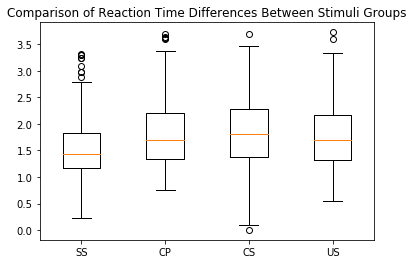

In [4]:
us = patients_data.loc[patients_data['stim'] == 'US']
ss = patients_data.loc[patients_data['stim'] == 'SS']
cp = patients_data.loc[patients_data['stim'] == 'CP']
cs = patients_data.loc[patients_data['stim'] == 'CS']

plt.boxplot([ss.rt.values, cp.rt.values, cs.rt.values, us.rt.values], 
            labels=('SS', 'CP', 'CS', 'US'),)
plt.title('Comparison of Reaction Time Differences Between Stimuli Groups')
plt.show()

In [5]:
ss_accuracy = (len([x for x in ss.response.values if x >= 1]) / len(ss.response.values)) * 100 
cp_accuracy = (len([x for x in cp.response.values if x >= 1]) / len(cp.response.values)) * 100
cs_accuracy = (len([x for x in cs.response.values if x >= 1]) / len(cs.response.values)) * 100
us_accuracy = (len([x for x in us.response.values if x >= 1]) / len(us.response.values)) * 100

print("SS Accuracy: " + str(ss_accuracy) + "%")
print("CP Accuracy: " + str(cp_accuracy) + "%")
print("CS Accuracy: " + str(cs_accuracy) + "%")
print("US Accuracy: " + str(us_accuracy) + "%")

SS Accuracy: 82.6923076923077%
CP Accuracy: 55.84415584415584%
CS Accuracy: 57.327586206896555%
US Accuracy: 69.46902654867256%


<Container object of 4 artists>

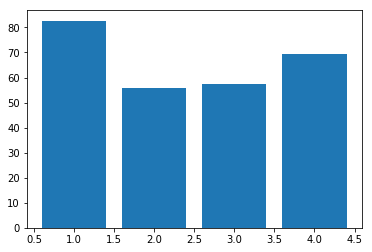

In [6]:
plt.bar([1,2,3,4], 
        [ss_accuracy, cp_accuracy, cs_accuracy, us_accuracy])

### Does the drift rate depend on stimulus type?


In [24]:
"""
Plot Drift Diffusion Model for controls
"""
patients_model = hddm.HDDM(patients_data, depends_on={'v': 'stim'}, bias=True)
patients_model.find_starting_values()
patients_model.sample(9000, burn=200, dbname='language_decision/models/patients', db='txt')

 [-----------------100%-----------------] 9000 of 9000 complete in 479.3 sec

#### Convergence Checks

Before carrying on with analysing the output of the model, we need to check that the markov chains have properly converged. There's a number of ways to do this, which the authors of the `hddm` library recommend$^1$. We'll begin by visually inspecting the MCMC posterior plots. 

Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


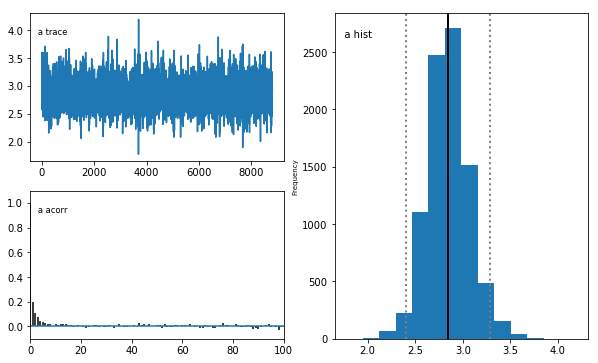

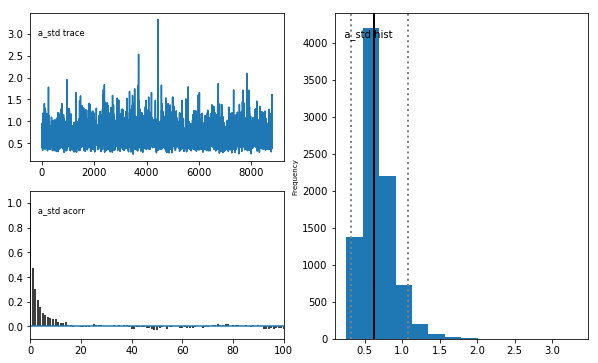

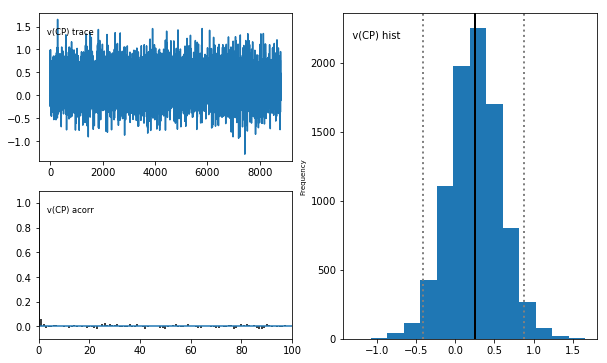

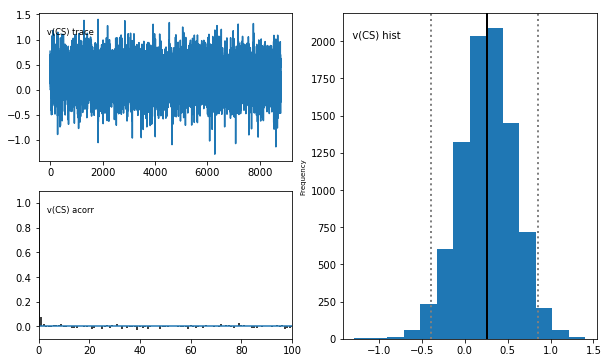

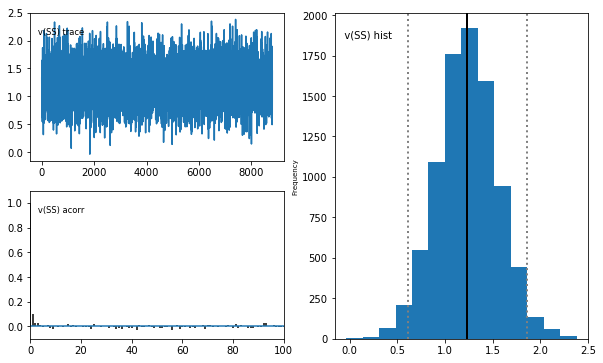

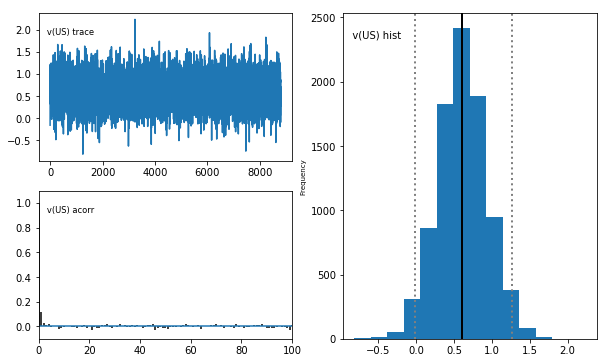

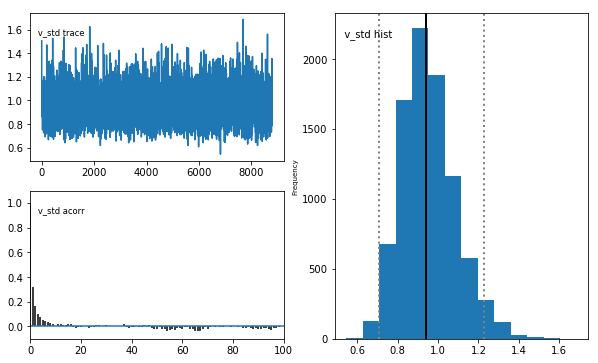

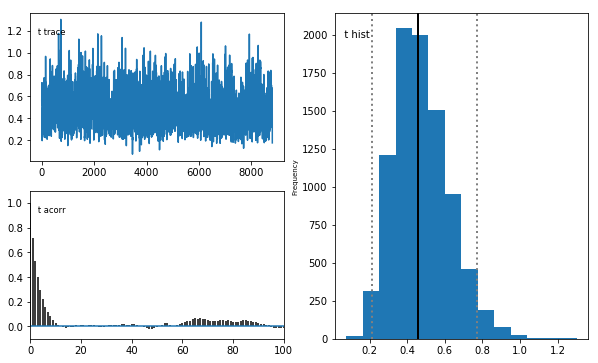

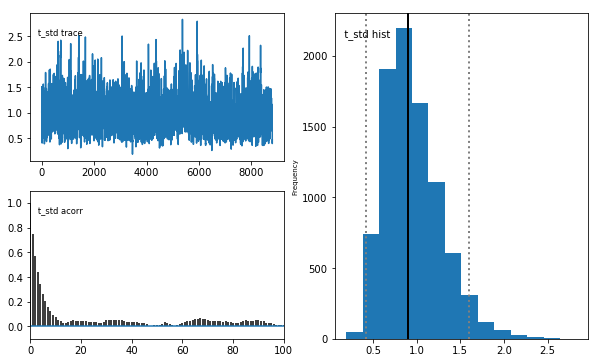

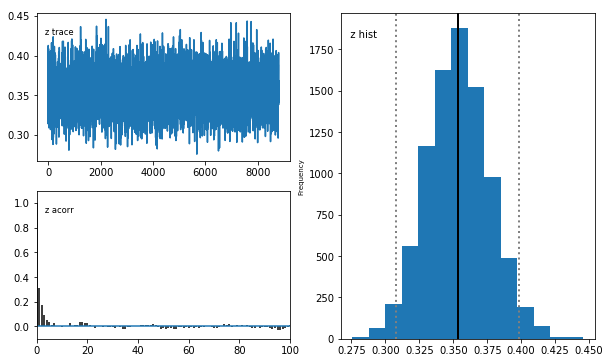

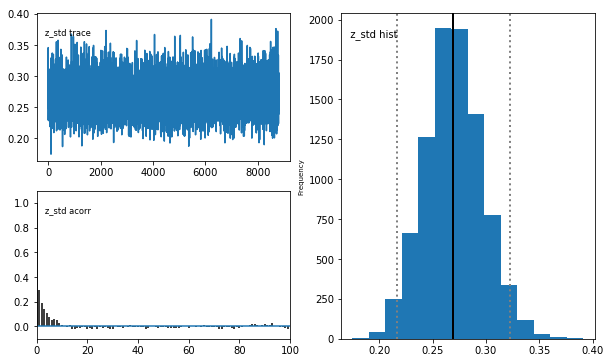

In [25]:
patients_model.plot_posteriors()

**PASS** - No problematic patterns, such as drifts or large jumps, can be in any of the traces above. Autocorrelation also drops to zero quite quickly when considering past samples - which is what we want.

We can also formally test for model convergence using the Gelman-Rubin R statistic$^2$, which compares the within- and between-chain variance of different runs of the same model; models converge if variables are between $0.98$ and $1.02$. A simple algorithm to check this is outlined below:

In [10]:
models = []
for i in range(5):
    m = hddm.HDDM(patients_data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models.append(m)
    
model_tools.check_convergence(models)

 [-----------------100%-----------------] 6000 of 6000 complete in 193.6 sec
No convergence problems detected!


True

**PASS** - Formal testing reveals no convergence problems; Gelman-Rubin R statistic values for all model variables fall within the desired range ($0.98$ to $1.02$)

#### Drift Rate Analysis

Here, we examine whether the type of stimulus significantly affects the drift rate of the decision-making process.

In [26]:
patients_stats = patients_model.gen_stats()
print("Threshold (a) Mean: " + str(patients_stats['mean']['a']) + " (std: " + str(patients_stats['std']['a']) + ")")
print("Non-Decision (t) Mean: " + str(patients_stats['mean']['t']) + " (std: " + str(patients_stats['std']['t']) + ")")
print("Bias (z) Mean: " + str(patients_stats['mean']['z']) + " (std: " + str(patients_stats['std']['z']) + ")")
print("SS Mean Drift Rate: " + str(patients_stats['mean']['v(SS)']) + " (std: " + str(patients_stats['std']['v(SS)']) + ")")
print("CP Mean Drift Rate: " + str(patients_stats['mean']['v(CP)']) + " (std: " + str(patients_stats['std']['v(CP)']) + ")")
print("CS Mean Drift Rate: " + str(patients_stats['mean']['v(CS)']) + " (std: " + str(patients_stats['std']['v(CS)']) + ")")
print("US Mean Drift Rate: " + str(patients_stats['mean']['v(US)']) + " (std: " + str(patients_stats['std']['v(US)']) + ")")

Threshold (a) Mean: 2.84880348193 (std: 0.222771908305)
Non-Decision (t) Mean: 0.4769044633 (std: 0.14972925801)
Bias (z) Mean: 0.353835404382 (std: 0.0230765810658)
SS Mean Drift Rate: 1.23559134359 (std: 0.315730137509)
CP Mean Drift Rate: 0.249634393768 (std: 0.328433221295)
CS Mean Drift Rate: 0.256484837656 (std: 0.315482527685)
US Mean Drift Rate: 0.61320853964 (std: 0.325945865976)


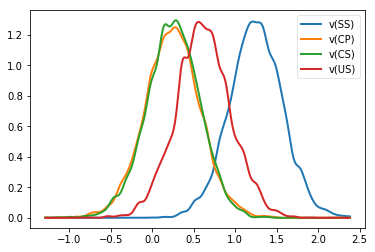

In [27]:
v_SS, v_CP, v_CS, v_US = patients_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_SS, v_CP, v_CS, v_US])

In [28]:
print('P(SS > US) = ' + str((v_SS.trace() > v_US.trace()).mean()))
print('P(CP > SS) = ' + str((v_CP.trace() > v_SS.trace()).mean()))
print('P(CS > SS) = ' + str((v_CS.trace() > v_SS.trace()).mean()))
print('P(CP > CS) = ' + str((v_CP.trace() > v_CS.trace()).mean()))
print('P(CP > US) = ' + str((v_CP.trace() > v_US.trace()).mean()))
print('P(CS > US) = ' + str((v_CS.trace() > v_US.trace()).mean()))

P(SS > US) = 0.915340909091
P(CP > SS) = 0.0185227272727
P(CS > SS) = 0.0115909090909
P(CP > CS) = 0.482613636364
P(CP > US) = 0.209886363636
P(CS > US) = 0.212272727273


- The drift rate for **CP** is significantly lower than both **SS** and **US**; no significant difference detected for **CS**  
- No other statistical significance detected at $p <0.05$

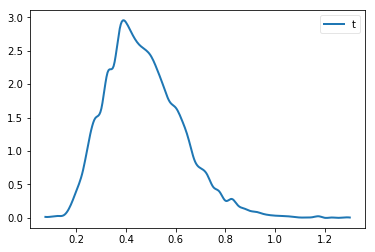

In [29]:
"""
Distribution for the non-decision time t
"""
time_nondec = patients_model.nodes_db.node[['t']]

hddm.analyze.plot_posterior_nodes(time_nondec)

### Does the stimulus type affect the distance  between the two boundaries (threshold)?

*Threshold* (or *a*) describes the relative difference in the distance between the upper and lower response boundaries of the DDM.

We explore whether stimulus type affects the threshold / distance between the two boundaries

In [19]:
patients_model_threshold = hddm.HDDM(patients_data, depends_on={'v': 'stim', 'a': 'stim'})
patients_model_threshold.find_starting_values()
patients_model_threshold.sample(10000, burn=200, dbname='language_decision/models/patients_threshold', db='txt')

 [-----------------100%-----------------] 10000 of 10000 complete in 372.5 sec

#### Convergence checks

In [23]:
models_threshold = []
for i in range(5):
    m = hddm.HDDM(patients_data, depends_on={'v': 'stim', 'a': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models_threshold.append(m)
    
model_tools.check_convergence(models_threshold)

 [-----------------100%-----------------] 6000 of 6000 complete in 256.1 sec
No convergence problems detected!


True

#### Threshold analysis

Since models converge, we can check the posteriors for significant differences in threshold between stimuli groups as we did for drift rates.

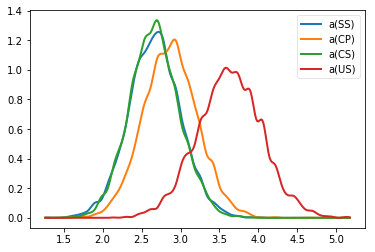

In [20]:
a_SS, a_CP, a_CS, a_US = patients_model_threshold.nodes_db.node[['a(SS)', 'a(CP)', 'a(CS)', 'a(US)']]

hddm.analyze.plot_posterior_nodes([a_SS, a_CP, a_CS, a_US])

In [21]:
print('P(SS > US) = ' + str((a_SS.trace() > a_US.trace()).mean()))
print('P(SS > CS) = ' + str((a_SS.trace() > a_CS.trace()).mean()))
print('P(CP > SS) = ' + str((a_CP.trace() > a_SS.trace()).mean()))
print('P(CP > CS) = ' + str((a_CP.trace() > a_CS.trace()).mean()))
print('P(CP > US) = ' + str((a_CP.trace() > a_US.trace()).mean()))
print('P(CS > US) = ' + str((a_CS.trace() > a_US.trace()).mean()))

P(SS > US) = 0.034693877551
P(SS > CS) = 0.499081632653
P(CP > SS) = 0.671428571429
P(CP > CS) = 0.671836734694
P(CP > US) = 0.0775510204082
P(CS > US) = 0.0307142857143


- Threshold for **US** is significantly larger than both **SS** & **CS**

In [22]:
print("a(US) mean: " + str(a_US.trace().mean()))
print("a(SS) mean: " + str(a_SS.trace().mean()))
print("a(CS) mean: " + str(a_CS.trace().mean()))
print("a(CP) mean: " + str(a_CP.trace().mean()))


a(US) mean: 3.62024197855
a(SS) mean: 2.68179328215
a(CS) mean: 2.67772080228
a(CP) mean: 2.87655353839
